# Continual learning

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one. We want to observe the catastrophic forgetting phenomenon. In our case, when performance increase on FashionMNIST, it decreases on MNIST.

In [ ]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss

In [ ]:
batch_size = 128
mnist_epochs = 15
fashion_epochs = 15
mnist = True
fashion = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import MNIST
train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

mnist_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [ ]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 4096)
        self.bn1 = nn.BatchNorm1d(4096)

        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, 10)
        self.bn3 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.bn1(self.fc1(x))
        x = self.bn2(self.fc2(x))
        return torch.softmax(self.bn3(self.fc3(x)), dim=1)

In [ ]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("MNIST - F1 score", score)
    return score

In [ ]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("Fashion - F1 score", score)
    return score

In [ ]:
cnn = NN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []
fashion_losses = []

# MNIST
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch.to(device))
            loss = criterion(output, y_batch.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch.to(device))
            loss = criterion(output, y_batch.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        fashion_losses.append(loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- MNIST ---
Epoch 0 - loss 1.7610942125320435
Epoch 1 - loss 1.6083394289016724
Epoch 2 - loss 1.5967389345169067
Epoch 3 - loss 1.5552501678466797
Epoch 4 - loss 1.5549801588058472
Epoch 5 - loss 1.6799181699752808
Epoch 6 - loss 1.5757337808609009
Epoch 7 - loss 1.547078013420105
Epoch 8 - loss 1.6234513521194458
Epoch 9 - loss 1.6174006462097168
Epoch 10 - loss 1.6694855690002441
Epoch 11 - loss 1.6590666770935059
Epoch 12 - loss 1.6590672731399536
Epoch 13 - loss 1.627817153930664
Epoch 14 - loss 1.5946282148361206
--- Scores ---
Fashion - F1 score 0.07055434300894001
MNIST - F1 score 0.8589334945590226
--- FashionMNIST ---
Epoch 0 - loss 1.9543066024780273
Epoch 1 - loss 1.6815333366394043
Epoch 2 - loss 1.6843434572219849
Epoch 3 - loss 1.6507102251052856
Epoch 4 - loss 1.6207560300827026
Epoch 5 - loss 1.645619511604309
Epoch 6 - loss 1.603488564491272
Epoch 7 - loss 1.6619213819503784
Epoch 8 - loss 1.6103252172470093
Epoch 9 - loss 1.6359186172485352
Epoch 10 - loss 1.635645

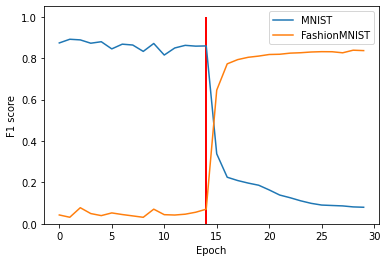

In [ ]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
plt.savefig("catastrophic_forgetting.png")
plt.show()